In [1]:
# pakages
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from CoolProp.CoolProp import PropsSI

In [2]:
# air properties functions
def rho_air(T, P): # Density of air in kg/m^3
    return PropsSI('D', 'T', T, 'P', P, 'Air')
def cp_air(T, P): # Specific heat capacity of air in J/(kg·K)
    return PropsSI('C', 'T', T, 'P', P, 'Air')
def mu_air(T, P): # Dynamic viscosity of air in Pa·s
    return PropsSI('VISCOSITY', 'T', T, 'P', P, 'Air')
def k_air(T, P): # Thermal conductivity of air in W/(m·K)
    return PropsSI('L', 'T', T, 'P', P, 'Air')  
def Pr_air(T, P): # Prandtl number of air
    return cp_air(T, P) * mu_air(T, P) / k_air(T, P)
# packed bed correlations
def Nu_pb(Re, Pr): # Nusselt number for packed bed
        return 2 + 1.1 * (Re**0.6) * (Pr**0.33) 
def epsilon(D,dp): # Void fraction for packed bed
    return 0.4272 - 4.516e-3 * (dp / D) + 7.881e-5 * (dp / D)**2
def Re_pb(dp , vf, T, P): # Reynolds number for packed bed
    return dp * vf * rho_air(T,P) / mu_air(T,P)
def h_pb(dp, vf, T, P): # Heat transfer coefficient for packed bed
    Re = Re_pb(dp, vf, T, P)
    Pr = Pr_air(T, P)
    Nu = Nu_pb(Re, Pr)
    k = k_air(T, P)
    return Nu * k / dp



In [3]:
# parameters
# Bed properties
L = 4.218  # m, length of the bed
D = 2  # m, diameter of the bed
Area =  np.pi * D**2/4  # m2, cross-sectional area of the bed
# Particle properties
Dp = 0.025  # m, particle diameter
eps = epsilon(D, Dp)  # void fraction
a = 6*(1 - eps) / Dp  # m2/m3, specific surface area
rho_p = 2768  # kg/m3, density of the particles
Cp_p = 852.1  # J/kgK, specific heat capacity of the particles
T_p0 = 298.15  # K, initial temperature of the particles

# Air properties and flow conditions
m_g = 1  # kg/s, mass flow rate of air
T_g_in = 923.15 # K, inlet temperature of air in the charging process
T_g_des = 298.15 # K, inlet temperature of air in the discharging process
P_sistem = 101325  # Pa, system pressure
rho_g = rho_air(T_g_in, P_sistem)  # kg/m3, density of air
vf = m_g / (rho_g * Area)  # m/s, superficial velocity of air
Cp_g = cp_air(T_g_in, P_sistem)  # J/kgK, specific heat capacity of air
# Heat transfer coefficient
h_air = h_pb(Dp, vf, T_g_in, P_sistem)  # W/m2K



# Properties printout
f = f"""Bed properties:
Length: {L} m
Diameter: {D} m
Cross-sectional area: {Area:.4f} m2
Particle properties:
Diameter: {Dp} m
Void fraction: {eps:.4f}
Specific surface area: {a:.2f} m2/m3
Density: {rho_p} kg/m3
Specific heat capacity: {Cp_p} J/kgK
Initial particle temperature: {T_p0-273.15:.2f} °C
Air properties and flow conditions:
Mass flow rate: {m_g} kg/s
Inlet temperature: {T_g_in-273.15:.2f} °C
System pressure: {P_sistem} Pa
Density: {rho_g:.2f} kg/m3
Superficial velocity: {vf:.4f} m/s
Specific heat capacity: {Cp_g:.2f} J/kgK
Heat transfer coefficient: {h_air:.2f} W/m2K
"""
print(f)
print(f"Reynold number packed bed: {Re_pb(Dp , vf, T_g_in, P_sistem):.2f}")
print(f"Nusselt number packed bed: {Nu_pb(Re_pb(Dp , vf, T_g_in, P_sistem), Pr_air(T_g_in, P_sistem)):.2f}")
dP = L*((150*mu_air(T_g_in,P_sistem)*vf*(1-eps)**2)/(Dp**2*eps**3) + ((1.75*rho_g*(1-eps)*vf**2)/(Dp*eps**3)))  # Pa
print(f"Pressure drop across the bed: {dP:.2f} Pa")

Bed properties:
Length: 4.218 m
Diameter: 2 m
Cross-sectional area: 3.1416 m2
Particle properties:
Diameter: 0.025 m
Void fraction: 0.4271
Specific surface area: 137.49 m2/m3
Density: 2768 kg/m3
Specific heat capacity: 852.1 J/kgK
Initial particle temperature: 25.00 °C
Air properties and flow conditions:
Mass flow rate: 1 kg/s
Inlet temperature: 650.00 °C
System pressure: 101325 Pa
Density: 0.38 kg/m3
Superficial velocity: 0.8327 m/s
Specific heat capacity: 1125.76 J/kgK
Heat transfer coefficient: 64.56 W/m2K

Reynold number packed bed: 193.74
Nusselt number packed bed: 25.32
Pressure drop across the bed: 721.09 Pa


# 0D implementation

###  Charge process 
Air:
$$
\frac{dT_g}{dt} = \frac{\dot{m_g}}{\rho_g A\epsilon L}(T_{g_{in}}-T_g) -\frac{ha}{\rho_g C_{p_{g}}\epsilon}(T_g-T_p)
$$
Packed Bed:
$$
\frac{dT_p}{dt} = \frac{ha}{\rho_p C_{p_{p}}(1-\epsilon)}(T_g-T_p)
$$
#### Initial Conditions t=0

$$
T_g = T_{p_{in}}
$$

$$
T_p = T_{p_{in}}
$$

### Discharge process

Air:
$$
\frac{dT_g}{dt} = \frac{\dot{m_g}}{\rho_g A\epsilon L}(T_{g_{in}}-T_g) +\frac{ha}{\rho_g C_{p_{g}}\epsilon}(T_p-T_g)
$$
Packed Bed:
$$
\frac{dT_p}{dt} = -\frac{ha}{\rho_p C_{p_{p}}(1-\epsilon)}(T_p-T_g)
$$

#### Initial Conditions t=0
$$
T_g = T_{g_{in}}
$$

$$
T_p = T_{p_{end}} \text{  temperature after the charge}
$$

In [4]:
def Charge_0D(t, y, h_air, a, rho_p, Cp_p, rho_g, Cp_g, eps, m_g, Area, T_g_in):
    Tg, Tp = y  # temperatures: air and particles
    # ODEs
    dTg_dt = (m_g / (rho_g * Area * eps * L)) * (T_g_in - Tg) \
             - (h_air * a / (rho_g * eps * Cp_g)) * (Tg - Tp)
    dTp_dt = (h_air * a / (rho_p * (1 - eps) * Cp_p)) * (Tg - Tp)
    return [dTg_dt, dTp_dt]

def Discharge_0D(t, y, h_air, a, rho_p, Cp_p, rho_g, Cp_g, eps, m_g, Area, T_g_des):
    Tg, Tp = y # temperatures: air and particles
    # ODEs
    dTg_dt = (m_g/(rho_g*Area*eps*L))*(T_g_des - Tg) + (h_air*a/(rho_g*eps*Cp_g))*(Tp - Tg)
    dTp_dt = -(h_air*a/(rho_p*(1-eps)*Cp_p))*(Tp - Tg)
    return [dTg_dt, dTp_dt]

In [5]:
# parameters for the simulation
dt = 0.5 # time step in seconds
total_time = 4*3600 # Total time in seconds
t_span = (0, total_time) # time span for the simulation
t_eval = np.arange(0, total_time, dt)

In [6]:
# simulation charging
# parameters:
T_g_in = 923.15 # K, inlet temperature of air in the charging process
rho_g = rho_air(T_g_in, P_sistem)  # kg/m3, density of air
Cp_g = cp_air(T_g_in, P_sistem)  # J/kgK, specific heat capacity of air
m_g = 1  # kg/s, mass flow rate of air
vf = m_g / (rho_g * Area)  # m/s, superficial velocity of air
h_air = h_pb(Dp, vf, T_g_in, P_sistem)  # W/m2K
T_p0 = 298.15  # K, initial temperature of the particles
y0 = [T_p0,T_p0]  # initial temperatures
sol_Charge_0D = solve_ivp(Charge_0D, t_span, y0, method='RK45', t_eval=t_eval, atol=1e-6, rtol=1e-6, args=(h_air, a, rho_p, Cp_p, rho_g, Cp_g, eps, m_g, Area, T_g_in))

In [7]:
# simulation discharging
# parameters:
T_g_des = 298.15 # K, inlet temperature of air in the charging process
rho_g = rho_air(T_g_des, P_sistem)  # kg/m3, density of air
Cp_g = cp_air(T_g_des, P_sistem)  # J/kgK, specific heat capacity of air
m_g = 1  # kg/s, mass flow rate of air
vf = m_g / (rho_g * Area)  # m/s, superficial velocity of air
h_air = h_pb(Dp, vf, T_g_des, P_sistem)  # W/m2K
T_p0 = sol_Charge_0D.y[1,-1]  # K, initial temperature of the particles
y0 = [T_g_des,T_p0]  # initial temperatures
sol_Discharge_0D = solve_ivp(Discharge_0D, t_span, y0, method='RK45', t_eval=t_eval, atol=1e-6, rtol=1e-6, args=(h_air, a, rho_p, Cp_p, rho_g, Cp_g, eps, m_g, Area, T_g_des))

# Plots

In [8]:
t_charge = sol_Charge_0D.t / 3600  # [h]
Tg_charge = sol_Charge_0D.y[0, :]
Tp_charge = sol_Charge_0D.y[1, :]
t_dis = sol_Discharge_0D.t / 3600
Tg_dis = sol_Discharge_0D.y[0, :]
Tp_dis = sol_Discharge_0D.y[1, :]


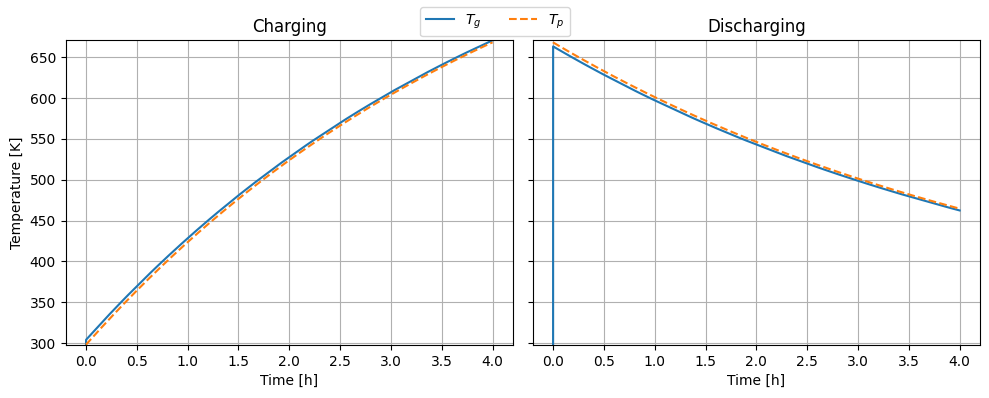

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axes[0].plot(t_charge, Tg_charge, label=r"$T_g$")
axes[0].plot(t_charge, Tp_charge, linestyle="--", label=r"$T_p$")
axes[0].set_title("Charging")
axes[0].set_xlabel("Time [h]")
axes[0].set_ylabel("Temperature [K]")
axes[0].grid(True)

axes[1].plot(t_dis, Tg_dis, label=r"$T_g$")
axes[1].plot(t_dis, Tp_dis, linestyle="--", label=r"$T_p$")
axes[1].set_title("Discharging")
axes[1].set_xlabel("Time [h]")
axes[1].grid(True)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2)

ymin = min(Tg_charge.min(), Tp_charge.min(), Tg_dis.min(), Tp_dis.min())
ymax = max(Tg_charge.max(), Tp_charge.max(), Tg_dis.max(), Tp_dis.max())
plt.ylim(ymin, ymax)

plt.tight_layout()
plt.show()

# 1D Implementation

###  Charge process 
Air:
$$
\frac{dT_g}{dt} = -\frac{\dot{m_g}}{\rho_g A\epsilon}\frac{dT_g}{dz} -\frac{ha}{\rho_g C_{p_{g}}\epsilon}(T_g-T_p)
$$
Packed Bed:
$$
\frac{dT_p}{dt} = \frac{ha}{\rho_p C_{p_{p}}(1-\epsilon)}(T_g-T_p)
$$

#### Initial Conditions t=0

$$
T_g = T_{p_{in}}
$$

$$
T_p = T_{p_{in}}
$$

#### Boundary conditions

$$
T_{g}(0,t) = T_{g_{in}}
$$

### discretization

backward:
$$
\frac{dT_g}{dz} = \frac{T_{g_{i}}-T_{g_{i-1}}}{\Delta z}
$$
Air:
$$
\frac{dT_{g_i}}{dt} = -\frac{\dot{m_g}}{\rho_g A\epsilon}\frac{T_{g_{i}}-T_{g_{i-1}}}{\Delta z} -\frac{ha}{\rho_g C_{p_{g}}\epsilon}(T_{g_i}-T_p)
$$

$$
\frac{dT_{g_i}}{dt} = \frac{\dot{m_g}}{\rho_g A\epsilon \Delta z}T_{g_{i-1}}-\left(\frac{ha}{\rho_g C_{p_{g}}\epsilon}+\frac{\dot{m_g}}{\rho_g A\epsilon \Delta z}\right) T_{g_i} +  \frac{ha}{\rho_g C_{p_{g}}\epsilon} T_p
$$

Packed Bed:
$$
\frac{dT_{p_i}}{dt} = \frac{ha}{\rho_p C_{p_{p}}(1-\epsilon)}(T_{g_i}-T_{p_i})
$$

$$
\frac{dT_{p_i}}{dt} = - \frac{ha}{\rho_p C_{p_{p}}(1-\epsilon)} T_{p_i} + \frac{ha}{\rho_p C_{p_{p}}(1-\epsilon)} T_{g_i} 
$$

### Discharge process

Air:
$$
\frac{dT_g}{dt} = \frac{\dot{m_g}}{\rho_g A\epsilon}\frac{dT_g}{dz} +\frac{ha}{\rho_g C_{p_{g}}\epsilon}(T_p-T_g)
$$
Packed Bed:
$$
\frac{dT_p}{dt} = -\frac{ha}{\rho_p C_{p_{p}}(1-\epsilon)}(T_p-T_g)
$$



#### Initial Conditions t=0
$$
T_{g}(z,0) = T_{g_{des}}
$$

$$
T_{p}(z,0) = T_{p_{carga}}
$$


#### Boundary conditions
$$
T_{g}(L,t) = T_{g_{des}}
$$

### Discretization

backward:
$$
\frac{dT_g}{dz} = \frac{T_{g_{i+1}}-T_{g_{i}}}{\Delta z}
$$
Air:

$$
\frac{dT_{g_i}}{dt} = \frac{\dot{m_g}}{\rho_g A\epsilon}\frac{T_{g_{i+1}}-T_{g_{i}}}{\Delta z} +\frac{ha}{\rho_g C_{p_{g}}\epsilon}(T_p-T_{g_i})
$$

$$
\frac{dT_{g_i}}{dt} = \frac{\dot{m_g}}{\rho_g A\epsilon \Delta z}T_{g_{i-1}}-\left(\frac{ha}{\rho_g C_{p_{g}}\epsilon}+\frac{\dot{m_g}}{\rho_g A\epsilon \Delta z}\right) T_{g_i} +  \frac{ha}{\rho_g C_{p_{g}}\epsilon} T_p
$$

Packed Bed:
$$
\frac{dT_{p_i}}{dt} = -\frac{ha}{\rho_p C_{p_{p}}(1-\epsilon)}(T_{p_i}-T_{g_i})
$$

$$
\frac{dT_{p_i}}{dt} = - \frac{ha}{\rho_p C_{p_{p}}(1-\epsilon)} T_{p_i} + \frac{ha}{\rho_p C_{p_{p}}(1-\epsilon)} T_{g_i} 
$$

In [10]:
def Charge_1D(t,y, h_air, a, rho_p, Cp_p, rho_g, Cp_g, epsilon, m_g, Area, dz):
    # Ecuación diferencial
    n = int(int(len(y)) / 2 - 1)
    T_p = y[0:n+1].copy()
    T_g = y[n + 1:].copy()
    dT_gdt = np.zeros(n+1)
    dT_pdt = np.zeros(n+1)
    for i in range(1,n+1):
        dT_gdt[i] =  m_g/(rho_g * Area * epsilon * dz) * T_g[i-1] - ( (h_air * a)/(rho_g * Cp_g * epsilon) + (m_g/(rho_g * Area * epsilon * dz)) ) * T_g[i] + (h_air * a)/(rho_g * Cp_g * epsilon) * T_p[i]
    for i in range(0,n+1):
        dT_pdt[i] = - (h_air * a)/(rho_p * Cp_p * (1 - epsilon)) * T_p[i] + (h_air * a)/(rho_p * Cp_p * (1 - epsilon)) * T_g[i]
    dy = np.empty_like(y)
    dy[0:n+1] = dT_pdt
    dy[n+1:] = dT_gdt
    return dy
def Discharge_1D(t,y, h_air, a, rho_p, Cp_p, rho_g, Cp_g, epsilon, m_g, Area, dz):
    # nodes
    n = int(int(len(y)) / 2 - 1)
    # temperature vectors
    T_p = y[0:n+1].copy()
    T_g = y[n + 1:].copy()
    # differential equations
    dT_gdt = np.zeros(n+1)
    dT_pdt = np.zeros(n+1)
    for i in range(0,n):
        dT_gdt[i] =  m_g/(rho_g * Area * epsilon * dz) * T_g[i+1] - (((h_air * a)/(rho_g * Cp_g * epsilon)) + (m_g/(rho_g * Area * epsilon * dz))) * T_g[i] + (h_air * a)/(rho_g * Cp_g * epsilon) * T_p[i]
    for i in range(0,n+1):
        dT_pdt[i] = - (h_air * a)/(rho_p * Cp_p * (1 - epsilon)) * T_p[i] + (h_air * a)/(rho_p * Cp_p * (1 - epsilon)) * T_g[i]
    dy = np.empty_like(y)
    dy[0:n+1] = dT_pdt
    dy[n+1:] = dT_gdt
    return dy

In [11]:
# simulation parameters
# nodes direction Z
n = 100
# time step
dt = 1 # s
# z vector
z = np.linspace(0, L, n + 1 ) # m
# spacing
dz = L/(n) # m
# initial time
t0 = 0  # s
# final time
tf = 3600*4  # s
# evaluation time
t_eval = np.arange(t0, tf, dt)
# time interval
t_span = (t0, tf)

In [12]:
# simulation charging
# parameters:
T_g_in = 923.15 # K, inlet temperature of air in the charging process
rho_g = rho_air(T_g_in, P_sistem)  # kg/m3, density of air
Cp_g = cp_air(T_g_in, P_sistem)  # J/kgK, specific heat capacity of air
m_g = 1  # kg/s, mass flow rate of air
vf = m_g / (rho_g * Area)  # m/s, superficial velocity of air
h_air = h_pb(Dp, vf, T_g_in, P_sistem)  # W/m2K
T_p0 = 298.15  # K, initial temperature of the particles

Tg_0 = np.ones(n + 1) * T_p0
Tp_0 = np.ones(n + 1) * T_p0
Tg_0[0] = T_g_in

y0 = np.concatenate([Tp_0, Tg_0])

sol_charge_1D = solve_ivp(Charge_1D, t_span, y0, method="BDF", t_eval=t_eval, atol=1e-6, rtol=1e-6, args=(h_air, a, rho_p, Cp_p, rho_g, Cp_g, eps, m_g, Area, dz))

In [14]:
# simulation discharging
# parameters:
T_g_des = 298.15 # K, inlet temperature of air in the charging process
rho_g = rho_air(T_g_des, P_sistem)  # kg/m3, density of air
Cp_g = cp_air(T_g_des, P_sistem)  # J/kgK, specific heat capacity of air
m_g = 1  # kg/s, mass flow rate of air
vf = m_g / (rho_g * Area)  # m/s, superficial velocity of air
h_air = h_pb(Dp, vf, T_g_des, P_sistem)  # W/m2K
Tg_0 = np.ones(n + 1) * T_g_des
Tp_0 = sol_charge_1D.y[0:n+1,-1]
Tg_0[-1] = T_g_des
y0 = np.concatenate([Tp_0, Tg_0])
sol_discharge_1D = solve_ivp(Discharge_1D, t_span, y0, method="BDF", t_eval=t_eval, atol=1e-6, rtol=1e-6, args=(h_air, a, rho_p, Cp_p, rho_g, Cp_g, eps, m_g, Area, dz))


# Plot

In [17]:
# results extraction
t_charge_1D = sol_charge_1D.t / 3600  # [h]
Tg_charge_1D = sol_charge_1D.y[n+1:,:] 
Tp_charge_1D = sol_charge_1D.y[0:n+1,:]
t_dis_1D = sol_discharge_1D.t / 3600
Tg_dis_1D = sol_discharge_1D.y[n+1:,:]
Tp_dis_1D = sol_discharge_1D.y[0:n+1,:]


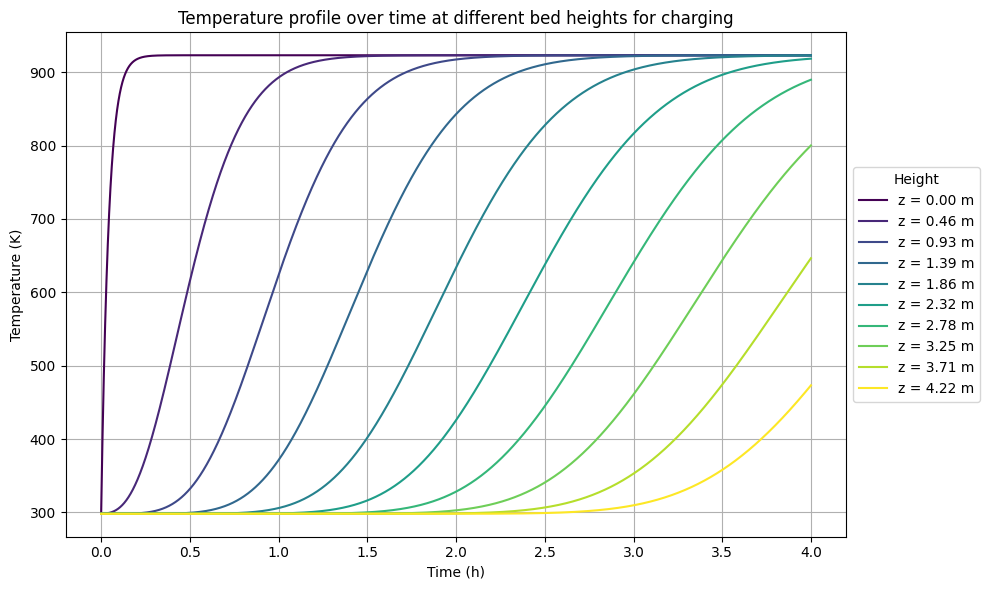

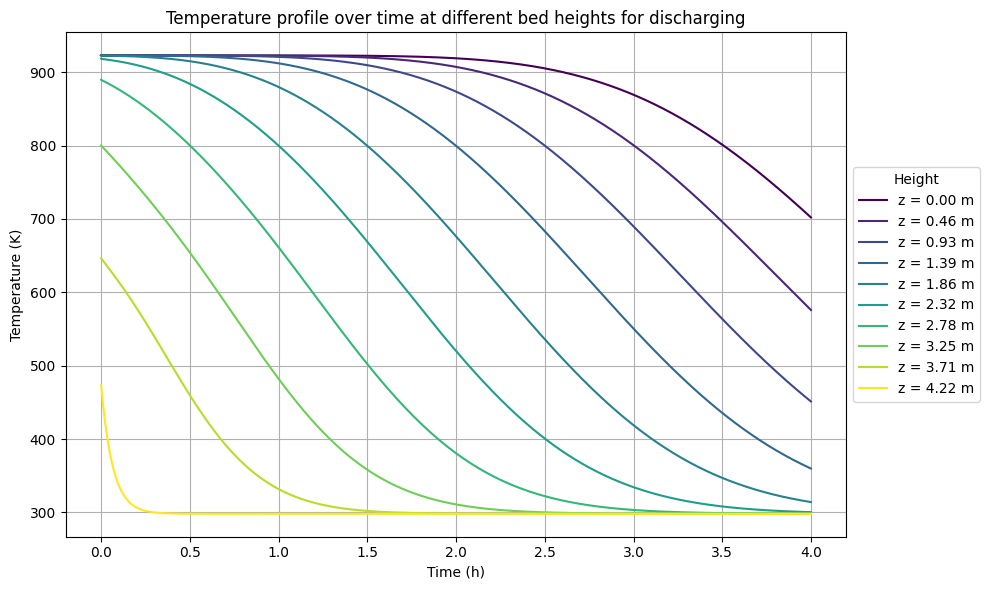

In [23]:
# select a subset of heights (for example, every 10 nodes)
# Charge
height_index = np.linspace(0, Tp_charge_1D.shape[0]-1, 10, dtype=int)
color = plt.cm.viridis(np.linspace(0, 1, len(height_index)))

plt.figure(figsize=(10, 6))
for idx, color in zip(height_index, color):
    plt.plot(t_charge_1D, Tp_charge_1D[idx, :], label=f'z = {z[idx]:.2f} m', color=color)

plt.xlabel('Time (h)')
plt.ylabel('Temperature (K)')
plt.title("Temperature profile over time at different bed heights for charging")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Height')
plt.grid(True)
plt.tight_layout()
plt.show()

# discharge
height_index = np.linspace(0, Tp_dis_1D.shape[0]-1, 10, dtype=int)
color = plt.cm.viridis(np.linspace(0, 1, len(height_index)))

plt.figure(figsize=(10, 6))
for idx, color in zip(height_index, color):
    plt.plot(t_dis_1D, Tp_dis_1D[idx, :], label=f'z = {z[idx]:.2f} m', color=color)
plt.xlabel('Time (h)')
plt.ylabel('Temperature (K)')
plt.title("Temperature profile over time at different bed heights for discharging")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Height')
plt.grid(True)
plt.tight_layout()
plt.show()

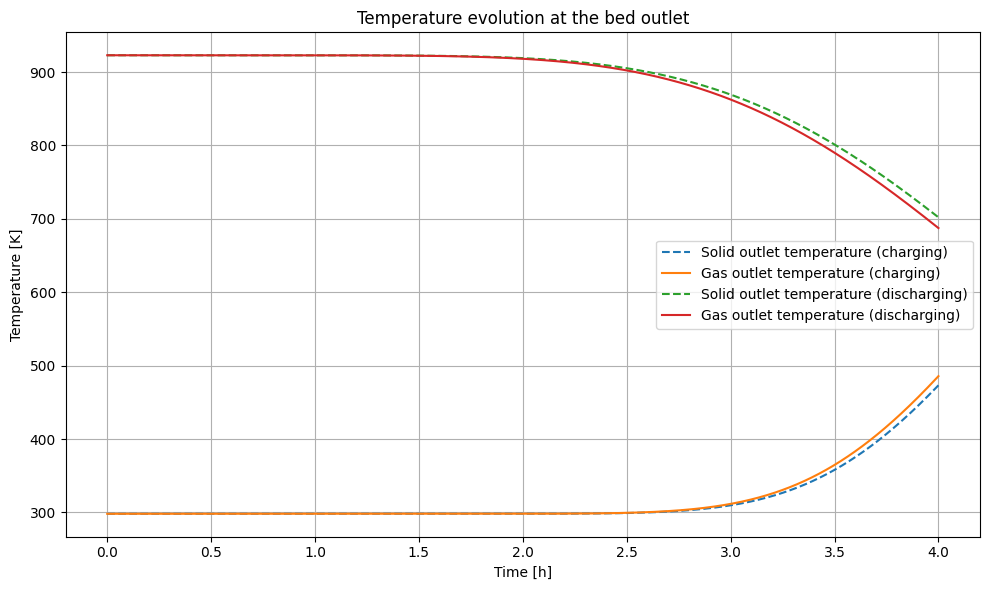

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(t_charge_1D[1:], Tp_charge_1D[-1, 1:], label='Solid outlet temperature (charging)', linestyle='--')
plt.plot(t_charge_1D[1:], Tg_charge_1D[-1, 1:], label='Gas outlet temperature (charging)')
plt.plot(t_dis_1D[1:], Tp_dis_1D[0, 1:], label='Solid outlet temperature (discharging)', linestyle='--')
plt.plot(t_dis_1D[1:], Tg_dis_1D[0, 1:], label='Gas outlet temperature (discharging)')
plt.xlabel('Time [h]')
plt.ylabel('Temperature [K]')
plt.title('Temperature evolution at the bed outlet')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()